<a href="https://colab.research.google.com/github/MathewBiddle/sandbox/blob/main/notebooks/MBON_occurrences_in_OBIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
import gspread
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import sklearn as skl

## For google spreadsheet reading you need to authenticate w/ google
from google.colab import auth
auth.authenticate_user()


from google.auth import default
creds, _ = default()


In [2]:
df_final = pd.DataFrame()

matt_howard_url = 'https://docs.google.com/spreadsheets/d/15BSlB2ThK0P6r4QwevdkyiH9812NLqQNayOu0V44Lpc/edit#gid=0'

gc = gspread.authorize(creds)
worksheet = gc.open_by_url(matt_howard_url)
responses = worksheet.worksheet('Sheet1')

df = pd.DataFrame(responses.get_all_records())

for dataset in df.loc[df['OBIS URL'] != '', 'OBIS URL']:
  #print(dataset.split("/")[-1])
  data = pd.DataFrame({'source': 'Matt Howard',
                       'obis_datasetid': [dataset.split("/")[-1]]} )
  df_final = pd.concat( [df_final, data] )

df_final

,source,obis_datasetid
0,Matt Howard,c9aaa0e9-8f6c-4553-a014-a857baba0680
0,Matt Howard,2ae2a2bd-8412-405b-8a9f-b71adc41d4c5
0,Matt Howard,a54a77db-7b42-4101-8d71-1adec3dd4ed5
0,Matt Howard,36693923-2abf-4237-8154-8016f32844a0
0,Matt Howard,731e318c-d692-4d6b-b4cc-edff0d385098
0,Matt Howard,230e0287-79c3-47f0-9aed-718b63c0a074
0,Matt Howard,fca3b113-b145-446c-a23c-3188090e43af
0,Matt Howard,52f99f08-fc90-4684-aea8-a015150968ea
0,Matt Howard,fbf4cb59-cef3-43be-b0ab-0dbab5f51740
0,Matt Howard,438b8f02-3421-4b2c-a5b2-5934ab76f47b


In [3]:
mbon_reg_url = 'https://docs.google.com/spreadsheets/d/1jBS8ASS27yV8APZ8Fh-tgX6dHdopwianrUZv0kbKcxw/edit#gid=1284796732'

gc = gspread.authorize(creds)
worksheet = gc.open_by_url(mbon_reg_url)
responses = worksheet.worksheet('Form Responses 1')

df = pd.DataFrame(responses.get_all_records())

In [4]:
for dataset in df.loc[df['Has the dataset been submitted to OBIS?']=='Yes','If yes to above, please include appropriate OBIS link(s) here.']:
  print(dataset.split("/")[-1])
  data = pd.DataFrame({'source': 'MBON',
                       'obis_datasetid': [dataset.split("/")[-1]]} )
  df_final = pd.concat( [df_final, data] )
df_final

d32266b4-d98d-4eed-8207-57dff1f14cc4
ab06f0c6-3de3-447a-b339-a8517f2c95ed
cfceb150-bbe2-4efb-8682-14cfc7167e7c
afef5da2-614b-4208-aee6-c2413ed5ab76
62b97724-da17-4ca7-9b26-b2a22aeaab51
fbf4cb59-cef3-43be-b0ab-0dbab5f51740


,source,obis_datasetid
0,Matt Howard,c9aaa0e9-8f6c-4553-a014-a857baba0680
0,Matt Howard,2ae2a2bd-8412-405b-8a9f-b71adc41d4c5
0,Matt Howard,a54a77db-7b42-4101-8d71-1adec3dd4ed5
0,Matt Howard,36693923-2abf-4237-8154-8016f32844a0
0,Matt Howard,731e318c-d692-4d6b-b4cc-edff0d385098
0,Matt Howard,230e0287-79c3-47f0-9aed-718b63c0a074
0,Matt Howard,fca3b113-b145-446c-a23c-3188090e43af
0,Matt Howard,52f99f08-fc90-4684-aea8-a015150968ea
0,Matt Howard,fbf4cb59-cef3-43be-b0ab-0dbab5f51740
0,Matt Howard,438b8f02-3421-4b2c-a5b2-5934ab76f47b


In [5]:
import json
from urllib.request import urlopen
import urllib.parse

base = 'https://api.obis.org/v3/occurrence'

cumulative_size = 0

for index, row in df_final.iterrows():

  datasetid = row['obis_datasetid']
  url = '{}?datasetid={}'.format(base,datasetid)

#url = https://api.obis.org/v3/occurrence?datasetid=ab06f0c6-3de3-447a-b339-a8517f2c95ed

  response= urlopen(url)

  data_json = json.loads(response.read())

  data = pd.DataFrame(data_json['results'])

  size = data_json['total']

  cumulative_size = cumulative_size + size

  #combined = pd.concat([combined, data],ignore_index=True)

  print("Found %i records." % size)
  print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?datasetid=',datasetid))

print("\nFound %i total occurrences." % cumulative_size )

Found 11724 records.
See in mapper at: https://mapper.obis.org/?datasetid=c9aaa0e9-8f6c-4553-a014-a857baba0680#
Found 698900 records.
See in mapper at: https://mapper.obis.org/?datasetid=2ae2a2bd-8412-405b-8a9f-b71adc41d4c5#
Found 245139 records.
See in mapper at: https://mapper.obis.org/?datasetid=a54a77db-7b42-4101-8d71-1adec3dd4ed5#
Found 28745 records.
See in mapper at: https://mapper.obis.org/?datasetid=36693923-2abf-4237-8154-8016f32844a0#
Found 940 records.
See in mapper at: https://mapper.obis.org/?datasetid=731e318c-d692-4d6b-b4cc-edff0d385098#
Found 47236 records.
See in mapper at: https://mapper.obis.org/?datasetid=230e0287-79c3-47f0-9aed-718b63c0a074#
Found 6288 records.
See in mapper at: https://mapper.obis.org/?datasetid=fca3b113-b145-446c-a23c-3188090e43af#
Found 74892 records.
See in mapper at: https://mapper.obis.org/?datasetid=52f99f08-fc90-4684-aea8-a015150968ea#
Found 53306 records.
See in mapper at: https://mapper.obis.org/?datasetid=fbf4cb59-cef3-43be-b0ab-0dbab5f

In [6]:
4511 + 4840 + 237709 + 1320 + 64841 + 53306

366527

In [7]:
try:
  import geopandas
except:
  !pip install geopandas

In [8]:
import geopandas as gpd

base = 'https://api.obis.org/v3/'

combined_data = gpd.GeoDataFrame()

location_data = gpd.GeoDataFrame() # initialize df

# build a list of the subset of fields you want back
fields = ['dataset_id','datasetID','id','decimalLatitude','decimalLongitude','species','aphiaID','date_year']
#fields = ['dataset_id','id']

f = "%2C".join([f"{v}" for v in fields])

#datasets = df.loc[df['Has the dataset been submitted to OBIS?']=='Yes','If yes to above, please include appropriate OBIS link(s) here.']

for index, row in df_final.iterrows():

  gpddf = gpd.GeoDataFrame()

  datasetid = row['obis_datasetid'] # grab the dataset uuid

  print("\nDataset ID:",datasetid)
  print("OBIS Dataset page: https://obis.org/dataset/{}".format(datasetid))

  url = 'https://api.obis.org/v3/occurrence?datasetid={}'.format(datasetid) # build the API url

  print("\tAPI request:", url)

  # find out how many occurrences we expect
  response = urlopen(url)
  data_json = json.loads(response.read())
  size = data_json['total']

  print("\tFound %i records." % size)

  # grab the locations
  url = base + 'occurrence/points?datasetid={}'.format(datasetid)
  response = urlopen(url)
  gpddf = gpd.read_file(url)

  gpddf['dataset_id'] = datasetid
  gpddf['source'] = row['source']

  location_data = pd.concat([location_data, gpddf])

print('Final shape:',location_data.shape)


Dataset ID: c9aaa0e9-8f6c-4553-a014-a857baba0680
OBIS Dataset page: https://obis.org/dataset/c9aaa0e9-8f6c-4553-a014-a857baba0680
	API request: https://api.obis.org/v3/occurrence?datasetid=c9aaa0e9-8f6c-4553-a014-a857baba0680
	Found 11724 records.

Dataset ID: 2ae2a2bd-8412-405b-8a9f-b71adc41d4c5
OBIS Dataset page: https://obis.org/dataset/2ae2a2bd-8412-405b-8a9f-b71adc41d4c5
	API request: https://api.obis.org/v3/occurrence?datasetid=2ae2a2bd-8412-405b-8a9f-b71adc41d4c5
	Found 698900 records.

Dataset ID: a54a77db-7b42-4101-8d71-1adec3dd4ed5
OBIS Dataset page: https://obis.org/dataset/a54a77db-7b42-4101-8d71-1adec3dd4ed5
	API request: https://api.obis.org/v3/occurrence?datasetid=a54a77db-7b42-4101-8d71-1adec3dd4ed5
	Found 245139 records.

Dataset ID: 36693923-2abf-4237-8154-8016f32844a0
OBIS Dataset page: https://obis.org/dataset/36693923-2abf-4237-8154-8016f32844a0
	API request: https://api.obis.org/v3/occurrence?datasetid=36693923-2abf-4237-8154-8016f32844a0
	Found 28745 records.

D

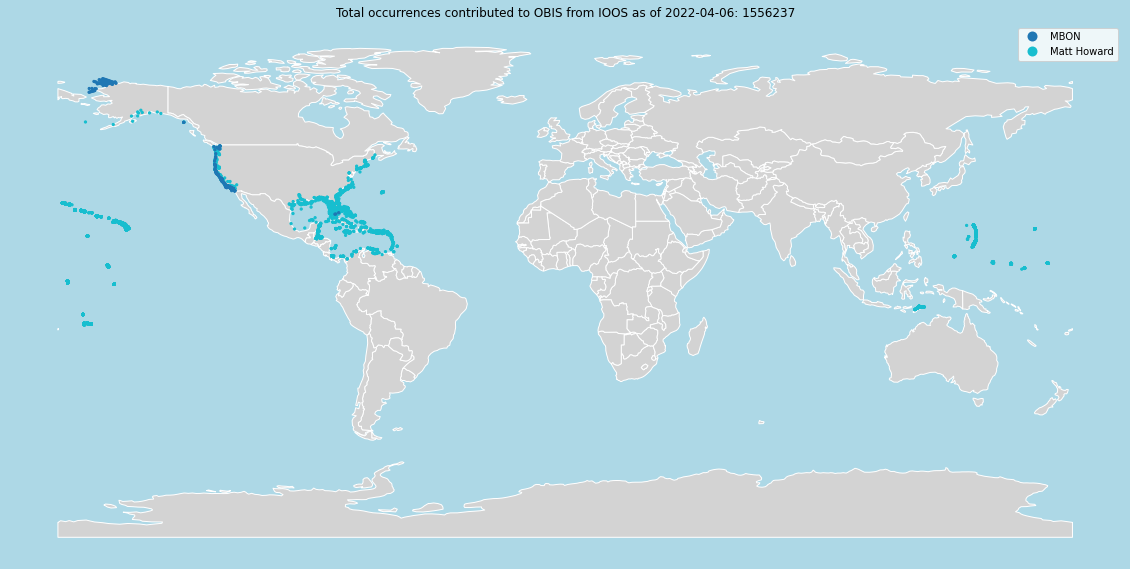

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(20,10), facecolor='lightblue')

location_data = location_data.to_crs("epsg:4326")
location_data.plot(ax=ax, markersize=5, column='source', zorder=10, legend=True)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.to_crs(location_data.crs)

world.plot(ax=ax, color='lightgrey', edgecolor='white', zorder=1)

now = datetime.now()

today = now.strftime("%Y-%m-%d")

plt.title("Total occurrences contributed to OBIS from IOOS as of %s: %i" % (today, cumulative_size ))

ax.set_axis_off();

plt.show()

In [10]:
!pip install matplotlib mapclassify
!pip install folium -U

In [14]:
location_data.explore(column='source', tooltip=True, tiles='CartoDB dark_matter')